In [2]:
import sys
sys.path.append("models/")

import itertools
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from setup import *
from dataloader import SurveyDataset
import mnl
from exp_version import get_hp_from_version_code


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Model Embeddings

In [8]:
data_version = '1571'

model_type = 'SAE'
model_code = 'M1_A1'
sampling = 's'

zoomlevel = 'zoom13'
output_dim = 3
model_run_date = '2208'

v1 = 'E'
v2 = 1

weight, lr, wd = get_hp_from_version_code(v1, v2)


variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

In [9]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       v1+"_"+str(v2)+"_"+model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [10]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Trip Data

In [11]:
tp = pd.read_csv(data_dir+"trips.csv")
n_alts = 4

In [12]:
print(tp['mode'].value_counts()/len(tp))

2    0.713060
1    0.132001
4    0.111893
3    0.043046
Name: mode, dtype: float64


In [13]:
tp['tract_1'] = tp['state_fips_1'].astype(str) + '_' + tp['county_fips_1'].astype(str)+ '_' + tp['tract_fips_1'].astype(str)
tp['tract_2'] = tp['state_fips_2'].astype(str) + '_' + tp['county_fips_2'].astype(str)+ '_' + tp['tract_fips_2'].astype(str)

tp['morning'] = (tp['dep_hour'] > 6) & (tp['dep_hour'] < 10)
tp['afternoon'] = (tp['dep_hour'] > 15) & (tp['dep_hour'] < 19)
tp['morning'] = tp['morning'].astype(int)
tp['afternoon'] = tp['afternoon'].astype(int)

tp['const'] = 1

def normalize_features(df, cols):
    for c in cols:
        df[c] = df[c]/df[c].max()
    return df

In [14]:
unique_ct = np.array(unique_ct)

x_embed = []
trip_filter = []
for t1, t2 in zip(tp['tract_1'], tp['tract_2']):
    if sum(unique_ct == t1) == 1 and sum(unique_ct == t2) == 1:
        x_embed.append(np.hstack((aggregate_embeddings[unique_ct == t1], aggregate_embeddings[unique_ct == t2])).flatten())
        trip_filter.append(True)
    else:
        trip_filter.append(False)
        

In [15]:
len(unique_ct)

1571

In [16]:
trip_filter = np.array(trip_filter)
x_embed = np.array(x_embed)
# x_trip = tp[['const','morning','afternoon','companion', 'distance', 
#          'from_home', 'to_home', 'purp_work', 'purp_school', 'purp_errand', 'purp_recreation', 
#          'ontime_important', '12_18yrs', '18_25yrs', '25_55yrs', '55+yrs', 
#          'disability', 'educ_col', 'educ_grad', 
#          'race_white', 'race_black', 'race_asian', 
#          'male', 'female', 
#          'emply_park', 'emply_transit', 'emply_veh', 'emply_wfh', 'emply_flex', 'emply_hours', 
#          'license', 'person_trips', 'person_transit', 'person_freq_transit', 
#          'hh_inc_0_30', 'hh_inc_30_60', 'hh_inc_60_100', 'hh_inc_100_150', 'hh_inc_150', 
#          'avg_pr_veh', 'home_own', 'home_house', 'home_condo']].to_numpy()[trip_filter]

# x = np.concatenate([x_trip, x_embed], axis=1)

x = x_embed

y = tp['mode'].astype(int).to_numpy() - 1
y = y[trip_filter]

origins = tp['tract_1'].to_numpy()[trip_filter]
destinations = tp['tract_2'].to_numpy()[trip_filter]

In [17]:
# dim_trip = x_trip.shape[1]
dim_embed = output_dim **2 * 2048

In [18]:
x_train, x_test, y_train, y_test,\
train_origin, test_origin, train_destination, test_destination = \
train_test_split(x,y,origins,destinations, test_size=0.2,random_state=42)

In [19]:
trainset = SurveyDataset(torch.tensor(x_train, dtype=torch.float32), 
                         torch.tensor(y_train, dtype=torch.long))
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float32), 
                        torch.tensor(y_test, dtype=torch.long))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

In [41]:
decay = []
no_decay = []
for p in model.named_parameters():
    if 'embedding.weight' in p[0]:
        decay.append(p)
    else:
        no_decay.append(p)

In [39]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-05
    maximize: False
    weight_decay: 5000.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [45]:
model.mnl_embedding.parameters()

<generator object Module.parameters at 0x7f55be929dd0>

In [48]:
wd_list = [5e-3, 5e-1, 5e+1, 5e+3]
lr_list = [1e-5]

loss_fn = nn.CrossEntropyLoss(reduction='mean')

for (lr, wd) in itertools.product(lr_list, wd_list):

    converged = 0
    
    model = mnl.MNL2(n_alts=n_alts, dim_embed=x_embed.shape[-1], dim_demo=0)
    optimizer = torch.optim.Adam([{'params': model.mnl_embedding.parameters(), 'weight_decay': wd},
                                  {'params': model.mnl_demo.parameters(), 'weight_decay': 0}], lr=lr)

    ref1 = 0
    ref2 = 0

    for epoch in range(1500):
        loss_ = 0
        correct = 0
        
        for batch, (x_batch, y_batch) in enumerate(trainloader):
            
            # Compute prediction and loss
            util = model(x_batch)
            loss = loss_fn(util, y_batch)
            loss_ += loss.item() * len(x_batch)

            pred = torch.argmax(util, dim=1)
            correct += torch.sum(pred == y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 5 == 0:
            loss_ /= len(trainset)
            train_acc = correct/len(trainset)
            print(f"[epoch: {epoch:>3d}] Train loss: {loss_:.4f} accuracy: {train_acc:.3f}")
            
            correct = 0
            test_loss_ = 0
            for batch, (x_batch, y_batch) in enumerate(testloader):
                util = model(x_batch)
                loss = loss_fn(util, y_batch)
                test_loss_ += loss.item()
                pred = torch.argmax(util, dim=1)
                correct += torch.sum(pred == y_batch)
            assert batch == 0 # there is only one batch in test
            test_acc = correct/len(testset)            
            print(f"[epoch: {epoch:>3d}] Test loss: {test_loss_:.4f} accuracy: {test_acc:.3f}")

            if epoch > 15:
                if (np.abs(loss_ - ref1)/ref1<0.001) & (np.abs(loss_ - ref2)/ref2<0.001):
                    print("Early stopping at epoch", epoch)
                    converged = 1
                    break
                if (ref1 < loss_) & (ref1 < ref2):
                    print("Diverging. stop.")
                    break
                if loss_ < best:
                    best = loss_
                    best_test = test_loss_
                    best_epoch = epoch
                    best_train_acc = train_acc
                    best_test_acc = test_acc
            else:
                best = loss_
                best_test = test_loss_
                best_epoch = epoch
                best_train_acc = train_acc
                best_test_acc = test_acc
                
            ref2 = ref1
            ref1 = loss_

    with open(out_dir+"SAE_D.csv", "a") as f:
        f.write("%.1E,%.1E,%.1E,%s,%s,%d,%.4f,%.4f,%.4f,%.4f,%d\n" % \
            ((weight, lr, wd)+(model_run_date, "MNL2", 
             best_epoch, best, best_test, best_train_acc, best_test_acc, converged)))
        

[epoch:   0] Train loss: 0.7164 accuracy: 0.737
[epoch:   0] Test loss: 0.6589 accuracy: 0.750
[epoch:   5] Train loss: 0.6471 accuracy: 0.755
[epoch:   5] Test loss: 0.6382 accuracy: 0.763
[epoch:  10] Train loss: 0.6382 accuracy: 0.760
[epoch:  10] Test loss: 0.6380 accuracy: 0.760
[epoch:  15] Train loss: 0.6342 accuracy: 0.763
[epoch:  15] Test loss: 0.6396 accuracy: 0.761
[epoch:  20] Train loss: 0.6320 accuracy: 0.763
[epoch:  20] Test loss: 0.6347 accuracy: 0.761
[epoch:  25] Train loss: 0.6284 accuracy: 0.764
[epoch:  25] Test loss: 0.6262 accuracy: 0.764
[epoch:  30] Train loss: 0.6275 accuracy: 0.765
[epoch:  30] Test loss: 0.6280 accuracy: 0.760
[epoch:  35] Train loss: 0.6245 accuracy: 0.766
[epoch:  35] Test loss: 0.6254 accuracy: 0.760
[epoch:  40] Train loss: 0.6226 accuracy: 0.767
[epoch:  40] Test loss: 0.6205 accuracy: 0.763
[epoch:  45] Train loss: 0.6229 accuracy: 0.767
[epoch:  45] Test loss: 0.6206 accuracy: 0.766
Diverging. stop.
[epoch:   0] Train loss: 0.7039 a

KeyboardInterrupt: 

In [16]:
for i in model.named_parameters():
    print(i)

('mnl_demo.weight', Parameter containing:
tensor([[-0.1018,  0.0170, -0.1642, -1.0524, -0.0398, -0.0567,  0.2732,  0.1050,
          0.0141,  0.2427, -0.1704,  0.0290,  0.2856,  0.2130,  0.3401, -0.3335,
          0.3321,  0.4742,  0.1030, -0.1459, -0.1863,  0.4310,  0.2631, -0.2342,
          0.3013, -0.1698, -0.0163,  0.0093,  0.0537, -0.1532, -0.0166,  0.1513,
         -0.2244,  0.1892,  0.0587,  0.1350,  0.2114,  0.1649, -0.5237, -0.0941,
          0.0158,  0.4718],
        [-0.0390,  0.0370,  0.1754,  0.1440,  0.1464,  0.0830, -0.2582, -0.5856,
          0.5439,  0.0333, -0.0553, -0.1301, -0.4307,  0.0181, -0.0664, -0.0552,
         -0.3455, -0.3635, -0.0645, -0.0710, -0.0753, -0.3322, -0.2366,  0.6363,
         -0.7697,  0.1067,  0.0365, -0.1299,  0.0480,  0.9677,  0.1128,  0.0217,
         -1.2872, -0.3158,  0.0702, -0.0625, -0.0897, -0.1213,  0.9698,  0.3509,
          0.3745, -0.4138],
        [-0.2449, -0.6703,  0.1917,  0.1229, -0.4042, -0.2352, -0.2372,  0.3413,
         -0

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [44]:
s1 = []
for i, t1, t2 in zip(tp.index, train_origin, train_destination):
    if (t1 == "17_197_881800") :
        s1.append(i)

s2 = []
for i, t1, t2 in zip(tp.index, train_origin, train_destination):
    if (t1 == "17_31_842100") :
        s2.append(i)

target = s2[0]

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


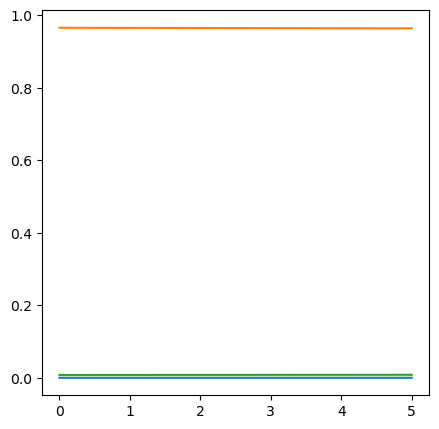

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


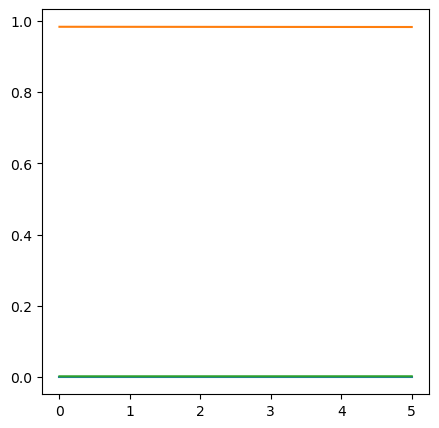

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


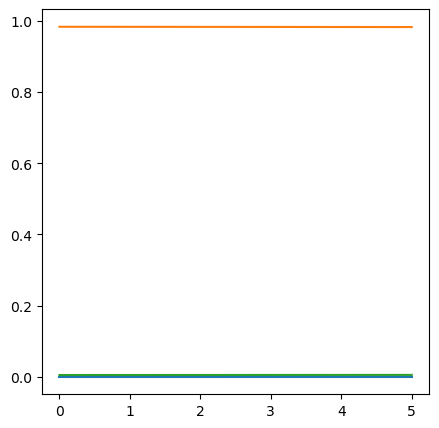

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


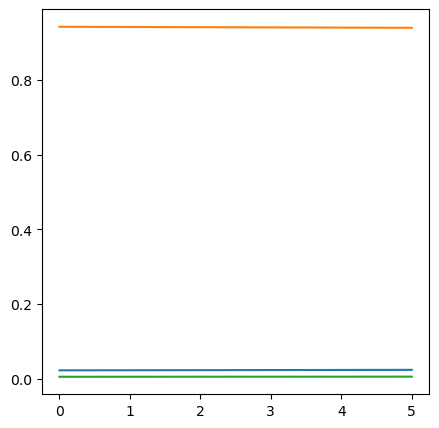

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


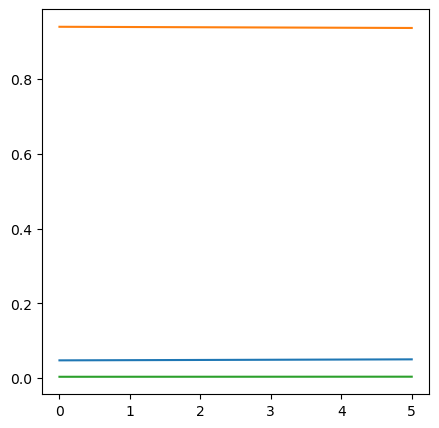

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


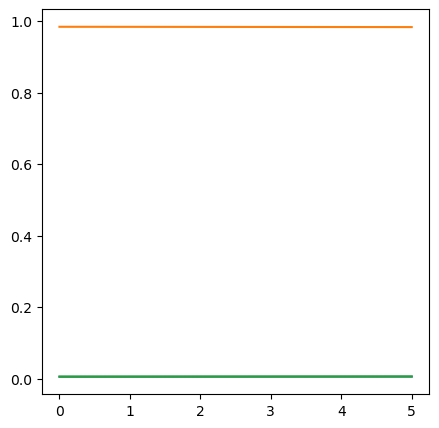

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


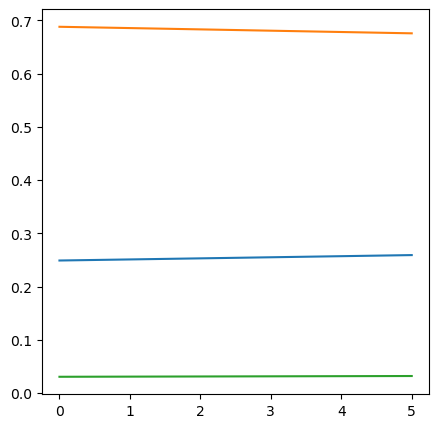

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


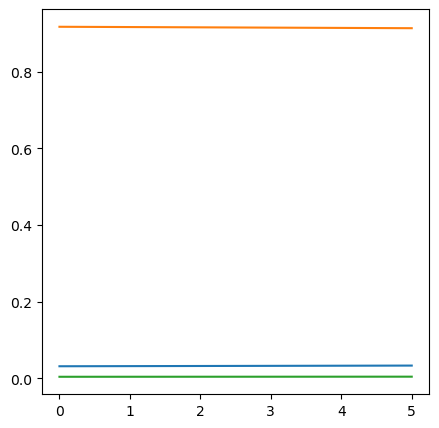

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


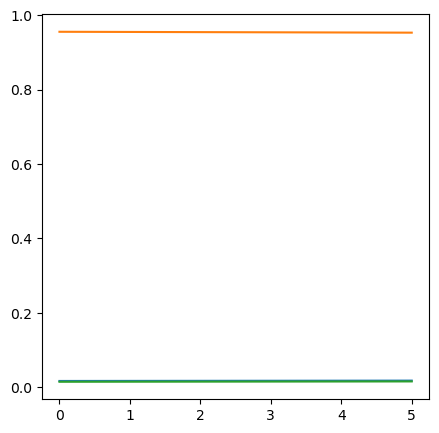

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


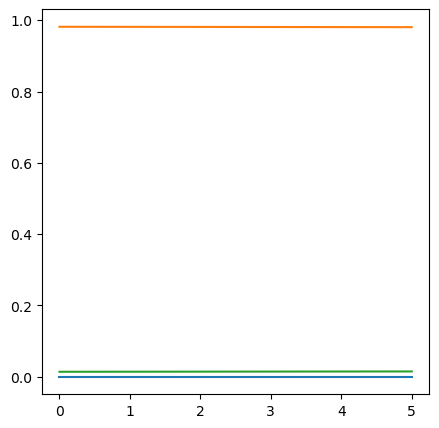

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


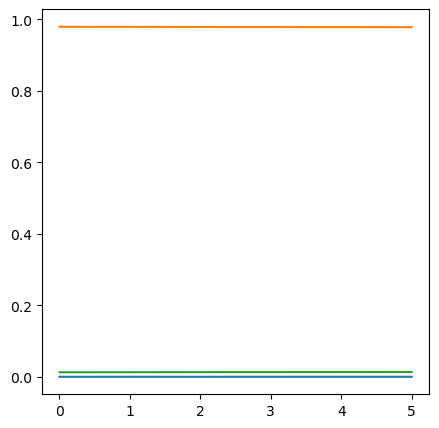

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


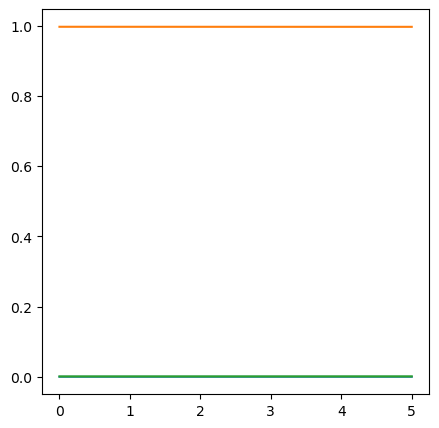

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


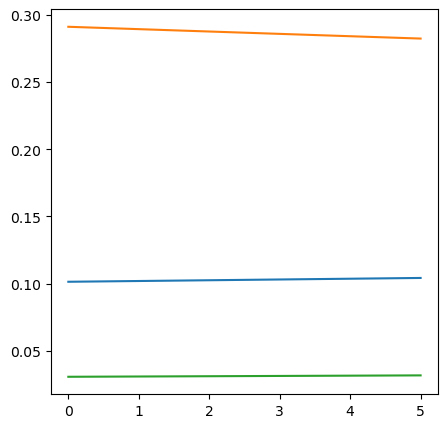

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


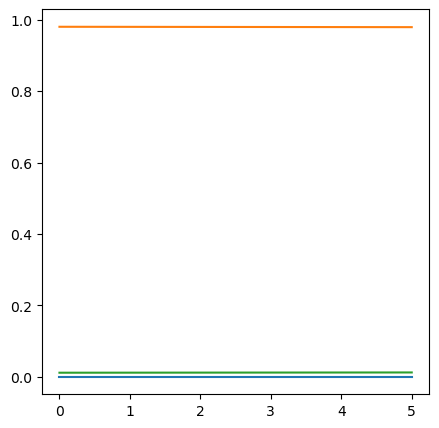

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


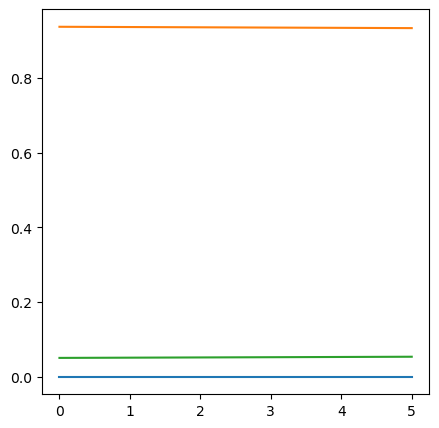

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


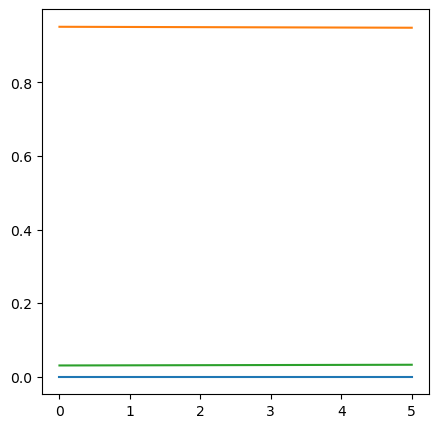

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


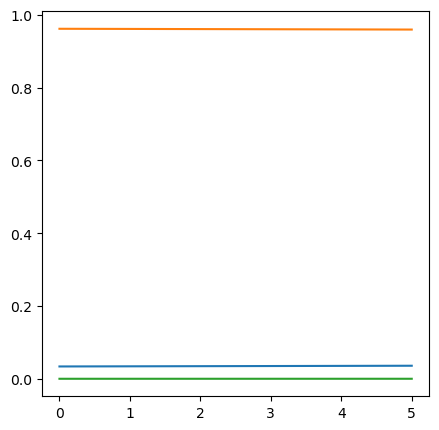

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


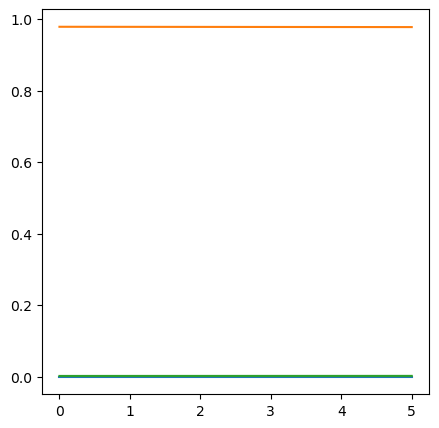

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


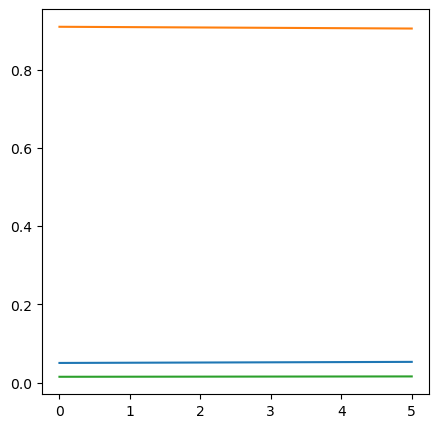

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


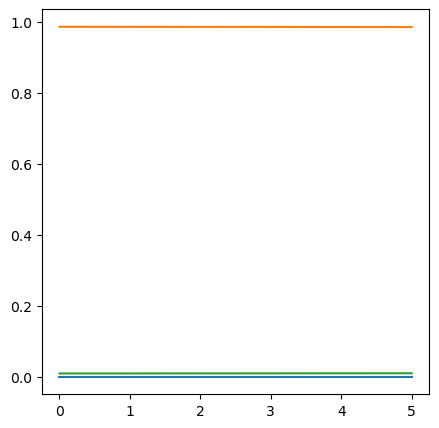

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


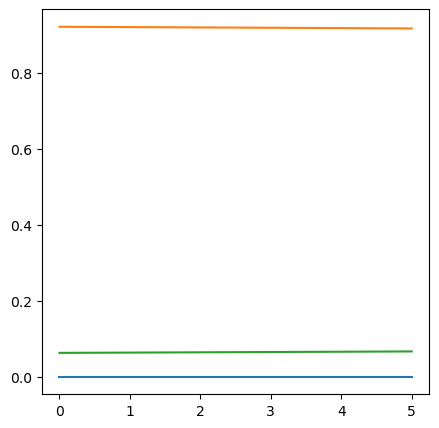

In [105]:
for j in s1:
    select = j
    for alpha in np.linspace(0, 1, 6):
        temp = x_train[select].copy()
        temp[dim_trip:dim_trip+dim_embed] = temp[dim_trip:dim_trip+dim_embed] * (1-alpha) + x_train[target, dim_trip:dim_trip+dim_embed] * (alpha)

        if alpha == 0:
            test_in = x_train[select].reshape(1, -1)
        else:
            test_in = np.concatenate([test_in, temp.reshape(1,-1)], axis=0)

    test_in = torch.tensor(test_in, dtype=torch.float32)

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    probs = F.softmax(model(torch.tensor(test_in))).detach().numpy()
    for i in [0,1,3]:
        ax.plot(probs[:,i])
    #     print(probs[:,i])
    plt.show()